# Dataset Exploration


Here we are going to explore the dataset with thousands of Mercado Libre items to see which features are more suitable for our model.


First we import the packages we need and set the palette for our plots.


In [1]:
import os

for _ in range(3):
    if os.path.exists(f'{os.getcwd()}/setup.py'):
        break
    os.chdir('..')
print('Current working directory:', os.getcwd())

Current working directory: /Users/dewith/Repos/new-or-used


In [139]:
import json
import re
import unicodedata

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from src.utils.config import get_dataset_path
from src.utils.styling import apply_styling, make_palette

In [3]:
# Seaborn
colors = make_palette()
palette = colors['palette']
apply_styling(colors)

# Pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
pd.set_option('display.max_colwidth', 50)

## Data Loading


Read the jsonl file


In [4]:
train_path = get_dataset_path('raw_items_train')
with open(train_path, 'r') as f:
    lines = f.readlines()
    dict_objects = [json.loads(line) for line in lines[:]]
    print('Number of lines:', len(lines))

Number of lines: 90000


Load the data into a pandas dataframe


In [7]:
df = pd.DataFrame.from_records(dict_objects)

## Data Exploration


### Target variable

Let's see the distribution of the target variable


In [ ]:
target_column = 'condition'

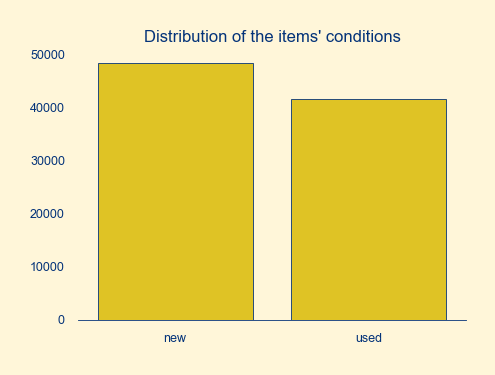

In [ ]:
plt.figure(figsize=(5, 3.5), dpi=100)
sns.barplot(
    df[target_column].value_counts(dropna=False),
    edgecolor=colors['lines'],
    linewidth=0.6,
    alpha=1,
)
plt.title("Distribution of the items' conditions")
plt.xlabel('')
plt.ylabel('')
sns.despine(left=True)
plt.show()

In [ ]:
df[target_column] = df[target_column].map({'new': 1, 'used': 0})
print('Majority class baseline:', df.condition.mean().round(3))

Majority class baseline: 0.537


### Schema


In [8]:
print(json.dumps(dict_objects[0], indent=2))

{
  "seller_address": {
    "country": {
      "name": "Argentina",
      "id": "AR"
    },
    "state": {
      "name": "Capital Federal",
      "id": "AR-C"
    },
    "city": {
      "name": "San Crist\u00f3bal",
      "id": "TUxBQlNBTjkwNTZa"
    }
  },
  "warranty": null,
  "sub_status": [],
  "condition": "new",
  "deal_ids": [],
  "base_price": 80.0,
  "shipping": {
    "local_pick_up": true,
    "methods": [],
    "tags": [],
    "free_shipping": false,
    "mode": "not_specified",
    "dimensions": null
  },
  "non_mercado_pago_payment_methods": [
    {
      "description": "Transferencia bancaria",
      "id": "MLATB",
      "type": "G"
    },
    {
      "description": "Acordar con el comprador",
      "id": "MLAWC",
      "type": "G"
    },
    {
      "description": "Efectivo",
      "id": "MLAMO",
      "type": "G"
    }
  ],
  "seller_id": 8208882349,
  "variations": [],
  "site_id": "MLA",
  "listing_type_id": "bronze",
  "price": 80.0,
  "attributes": [],
  "buying_mod

#### Dtypes


In [9]:
dtypes = {k: type(v) for k, v in dict_objects[0].items()}
for dtype in set(dtypes.values()):
    print(f'{dtype}:')
    for k, v in dtypes.items():
        if v == dtype:
            print(f'  {k}')
    print()

<class 'bool'>:
  accepts_mercadopago
  automatic_relist

<class 'str'>:
  condition
  site_id
  listing_type_id
  buying_mode
  listing_source
  parent_item_id
  category_id
  last_updated
  international_delivery_mode
  id
  currency_id
  thumbnail
  title
  date_created
  secure_thumbnail
  status
  permalink

<class 'dict'>:
  seller_address
  shipping

<class 'list'>:
  sub_status
  deal_ids
  non_mercado_pago_payment_methods
  variations
  attributes
  tags
  coverage_areas
  descriptions
  pictures

<class 'float'>:
  base_price
  price

<class 'int'>:
  seller_id
  stop_time
  initial_quantity
  start_time
  sold_quantity
  available_quantity

<class 'NoneType'>:
  warranty
  official_store_id
  differential_pricing
  original_price
  video_id
  catalog_product_id
  subtitle



### Boolean columns

#### Accepts mercadopago

#### Automatic relist

### Categorical features

### Numerical features

### Dictionary columns


##### Seller address

Extract location information from the dictionary


In [15]:
location_features = ['country', 'state', 'city']
for feature in location_features:
    df[feature] = df['seller_address'].apply(
        lambda x, k=feature: x.get(k, {}).get('name', None)
    )

df.drop(columns=['seller_address'], inplace=True)

##### Shipping

Extract shipping information from the dictionary


In [16]:
shipping_df = pd.json_normalize(df['shipping'])
shipping_df.columns = [
    'local_pick_up',
    'shipping_methods',
    'shipping_tags',
    'free_shipping',
    'shipping_mode',
    'dimensions',
    'shipping_free_methods',
]

df = pd.concat([df.drop('shipping', axis=1), shipping_df], axis=1)

### List columns


In [17]:
list_cols = [
    'sub_status',
    'deal_ids',
    'non_mercado_pago_payment_methods',
    'variations',
    'attributes',
    'tags',
    'coverage_areas',
    'descriptions',
    'pictures',
]

In [18]:
for col in list_cols:
    print(col)
    try:
        values, counts = np.unique(df[col].values, return_counts=True)
        print('Unique values:', len(values))
        if len(values) < 10:
            print('\n'.join([f'{v}: {c}' for v, c in zip(values, counts)]))
    except Exception as e:
        print(e)
    print('-' * 60)

sub_status
Unique values: 4
[]: 89109
['deleted']: 7
['expired']: 13
['suspended']: 871
------------------------------------------------------------
deal_ids
Unique values: 31
------------------------------------------------------------
non_mercado_pago_payment_methods
'<' not supported between instances of 'dict' and 'dict'
------------------------------------------------------------
variations
'<' not supported between instances of 'dict' and 'dict'
------------------------------------------------------------
attributes
'<' not supported between instances of 'dict' and 'dict'
------------------------------------------------------------
tags
Unique values: 8
[]: 22412
['dragged_bids_and_visits']: 65315
['dragged_visits']: 464
['dragged_visits', 'free_relist']: 259
['good_quality_thumbnail']: 346
['good_quality_thumbnail', 'dragged_bids_and_visits']: 1191
['poor_quality_thumbnail']: 3
['poor_quality_thumbnail', 'dragged_bids_and_visits']: 10
--------------------------------------------

##### Substatus

Make it a string instead of a list


In [19]:
df['sub_status'] = df['sub_status'].apply(lambda x: x[0] if x else np.nan)

#### Deal ids

Drop this column since most of the values are empty


In [22]:
df.drop(columns=['deal_ids'], inplace=True)

#### Non mercado pago payment methods

Make each payment method a flag column


In [45]:
all_payment_methods = set()
for x in df['non_mercado_pago_payment_methods'].values:
    if x:
        for method in x:
            all_payment_methods.add(method['description'])
all_payment_methods

{'Acordar con el comprador',
 'American Express',
 'Cheque certificado',
 'Contra reembolso',
 'Diners',
 'Efectivo',
 'Giro postal',
 'MasterCard',
 'Mastercard Maestro',
 'MercadoPago',
 'Tarjeta de crédito',
 'Transferencia bancaria',
 'Visa',
 'Visa Electron'}

In [47]:
def extract_payment_methods(payment_methods):
    """Extract payment methods from a list of dictionaries."""
    if not payment_methods:
        return None

    card_prefixes = {'visa', 'mastercard', 'american'}

    def categorize_method(method):
        description = method['description'].lower()
        return (
            'pay_tarjeta'
            if any(description.startswith(prefix) for prefix in card_prefixes)
            else f'pay_{description.split()[0]}'
        )

    unique_methods = {categorize_method(method) for method in payment_methods}
    return ' / '.join(unique_methods)


# Extract payment methods
payment_df = df['non_mercado_pago_payment_methods'].apply(extract_payment_methods)
payment_methods_dummies = payment_df.str.get_dummies(sep=' / ')
payment_methods_dummies['n_payment_methods'] = payment_methods_dummies.sum(axis=1)
df = pd.concat([df, payment_methods_dummies], axis=1)
df.drop(columns=['non_mercado_pago_payment_methods'], inplace=True)

#### Variations

Make a binary column if the item has variations or not


In [50]:
df['has_variations'] = df['variations'].apply(lambda x: 1 if x else 0)
df.drop(columns=['variations'], inplace=True)

#### Attributes

Extract the attributes from the dictionary and use the most informative ones


In [51]:
def clean_name(name):
    """Normalize attribute names"""
    name = re.sub(r'[^\w\s]', '', name)
    name = re.sub(r'\s+', ' ', name)
    name = re.sub(r'\b(de|del)\s+', '', name, flags=re.IGNORECASE)
    name = name.replace(' ', '_').lower().strip()
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    return name


# Flatten and consolidate attributes
len_mask = df['attributes'].apply(lambda x: len(x)) > 0
attributes_df = pd.json_normalize(df.loc[len_mask, 'attributes'])
all_attributes = attributes_df.values.tolist()

attributes = []
for row in all_attributes:
    for attribute in row:
        if attribute:
            attribute_name = clean_name(attribute['name'])
            value = clean_name(attribute['value_name'])
            attributes.append({'attribute': attribute_name, 'value': value})

attributes_df = pd.DataFrame(attributes)
common_attributes = (attributes_df['attribute'].value_counts() >= 100).index.tolist()

In [52]:
def consolidate_attributes(attributes):
    """Consolidate attributes"""
    new_attributes = {}
    for attribute in attributes:
        attribute_name = clean_name(attribute['name'])
        value = clean_name(attribute['value_name'])
        if (attribute_name in common_attributes) and ('pieza' not in attribute_name):
            new_attributes[f'attr_{attribute_name}'] = value

    return new_attributes


# Consolidate attributes
attributes_dict_df = df['attributes'].apply(consolidate_attributes).to_frame()
attributes_normalized_df = pd.json_normalize(attributes_dict_df['attributes'])
attributes_dict_df = pd.concat([df[['condition']], attributes_normalized_df], axis=1)
attributes_dict_df.fillna('missing', inplace=True)

The hypothesis is that what is informative is not the value of the attribute but if the
item has that attribute or not. For example, the value of the attribute "antigüedad" is not
informative, but if the item has the attribute "antigüedad" is informative for our task.

To test this hypothesis we will use the gini impurity to see which attributes are more informative.


In [53]:
def gini_impurity(value_counts):
    n = value_counts.sum()
    p_sum = 0
    for key in value_counts.keys():
        p_sum = p_sum + (value_counts[key] / n) * (value_counts[key] / n)
    gini = 1 - p_sum
    return gini


# Calculate Gini Impurity for the class
class_value_counts = attributes_dict_df[target_column].value_counts()
gini_class = gini_impurity(class_value_counts)

# Calculate Gini Impurity for each attribute
gini_attiribute = {}
for attribute_name in attributes_dict_df.columns[1:]:
    # We remove the missing values to compute the gini of the attribute alone.
    # Since most items have no attributes, the nulls bias the gini a lot.
    attributes_dict_df_A = attributes_dict_df[['condition', attribute_name]].query(
        f'{attribute_name} != "missing"'
    )
    attribute_values = attributes_dict_df_A[attribute_name].value_counts()
    gini_A = 0
    for key in attribute_values.keys():
        key_mask = attributes_dict_df_A[attribute_name] == key
        df_k = attributes_dict_df_A[target_column][key_mask].value_counts()
        n_k = attribute_values[key]
        n = attributes_dict_df_A.shape[0]
        gini_k = gini_impurity(df_k)
        gini_A += (n_k / n) * gini_k

    gini_attiribute[attribute_name] = gini_A

gini_df = pd.DataFrame.from_dict(gini_attiribute, orient='index', columns=['gini'])

Let's plot the distribution of the gini impurity for each attribute



Gini Impurity of the class is 0.497


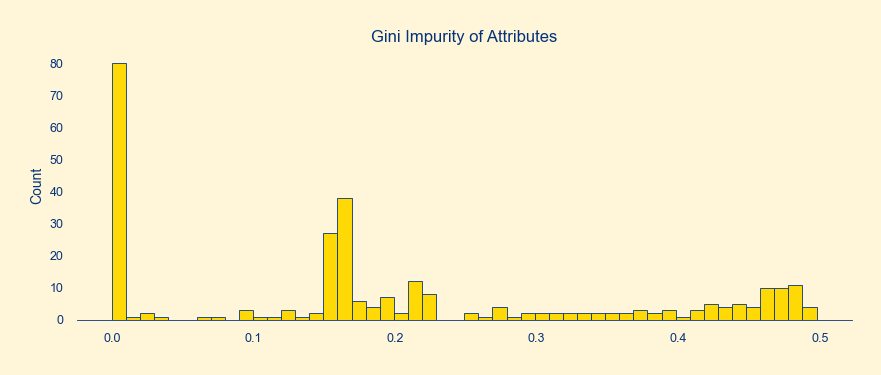

In [55]:
print(f'\nGini Impurity of the class is {gini_class:.3f}')

plt.figure(figsize=(10, 3.5), dpi=100)
sns.histplot(
    gini_df.gini,
    bins=50,
    stat='count',
    color='#fed906',
    edgecolor=colors['lines'],
    linewidth=0.6,
    alpha=1,
)
plt.title('Gini Impurity of Attributes')
plt.xlabel('')
sns.despine(left=True)
plt.show()

Let's keep the attributes below 0.15 of gini impurity


In [65]:
valid_attributes = gini_df[gini_df['gini'] < 0.15].index.tolist()
print(f'Number of valid attributes: {len(valid_attributes)}')

Number of valid attributes: 98


Now let process the column in the main dataframe


In [76]:
def consolidate_attributes(attributes):
    """Consolidate attributes"""
    if not attributes:
        return None
    new_attributes = {}
    for attribute in attributes:
        attribute_name = 'attr_' + clean_name(attribute['name'])
        value = clean_name(attribute['value_name'])
        if attribute_name in valid_attributes:
            new_attributes[f'{attribute_name}'] = value
    return new_attributes


# Consolidate attributes
attributes_series = df['attributes'].apply(consolidate_attributes)
attributes_normalized_df = pd.json_normalize(attributes_series)
attributes_normalized_df['n_attributes'] = attributes_normalized_df.notna().sum(axis=1)

# Join with original DataFrame
df = pd.concat([df, attributes_normalized_df], axis=1)
df.drop(columns=['attributes'], inplace=True)

#### Tags

Turn the tags into flag columns


In [80]:
df['tags_str'] = df['tags'].apply(lambda x: ' / '.join(x))
tags_dummies = df['tags_str'].str.get_dummies(sep=' / ')
df = pd.concat([df, tags_dummies], axis=1)
df.drop(columns=['tags', 'tags_str'], inplace=True)

#### Coverage areas

Drop this column since it is empty


In [ ]:
# coverage_areas
# Drop this column since it is empty
df.drop(columns=['coverage_areas'], inplace=True)

#### Descriptions

Drop descriptions since they are all unique


In [ ]:
print(df.descriptions.sample(3))
df[['descriptions']].apply(lambda x: x.str.len().value_counts(dropna=False))

#### Pictures

Only keep the number of pictures and the average resolution


In [82]:
df['n_pictures'] = df['pictures'].apply(len)

In [112]:
def get_pixels(size):
    """Get the number of pixels of a picture."""
    w, h = map(int, size.split('x'))
    return w * h


df['pixels_per_picture'] = df['pictures'].apply(
    lambda x: np.median(
        [get_pixels(picture['size']) for picture in x if picture['size']]
    )
    if x
    else np.nan
)

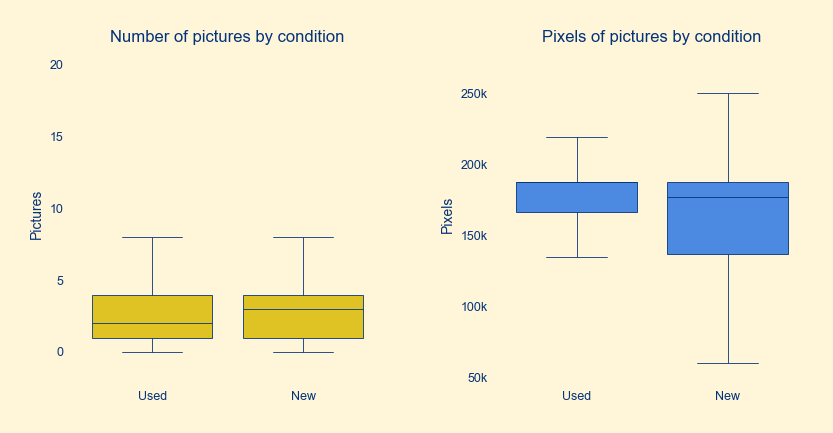

In [140]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=100)

std_params = {
    'x': 'condition',
    'data': df,
    'fliersize': 0,
    'linewidth': 0.6,
    'linecolor': colors['lines'],
    'legend': False,
}

# Number of pictures plot
sns.boxplot(y='n_pictures', ax=axes[0], **std_params)
axes[0].set_title('Number of pictures by condition')
axes[0].set_ylabel('Pictures')
axes[0].set_ylim(None, 21)

# Image size plot
sns.boxplot(y='pixels_per_picture', color=palette[2], ax=axes[1], **std_params)
axes[1].set_title('Pixels of pictures by condition')
axes[1].set_ylabel('Pixels')
axes[1].set_ylim(50_000, 280_000)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1_000:.0f}k'))

# Common ax settings
for ax in axes:
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Used', 'New'])
    ax.spines[['left', 'bottom']].set_visible(False)

plt.tight_layout(w_pad=5)
plt.show()